In [1]:
# pip install kagglehub

In [2]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("shubhambathwal/flight-price-prediction")

# print("Path to dataset files:", path)

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
from shapely.geometry import Point
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import *

In [4]:
data=pd.read_csv(r"C:\Users\segev\code_notebooks\Clean_Dataset.csv")

In [5]:
(data.price*0.04).describe()

count    300153.000000
mean        835.586421
std         907.910695
min          44.200000
25%         191.320000
50%         297.000000
75%        1700.840000
max        4922.840000
Name: price, dtype: float64

In [6]:
123071

123071

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [8]:
pd.DataFrame(data.airline.value_counts())

,airline
Vistara,127859
Air_India,80892
Indigo,43120
GO_FIRST,23173
AirAsia,16098
SpiceJet,9011


In [9]:
len(set(data.flight))

1561

In [10]:
pd.DataFrame(data.source_city.value_counts())

,source_city
Delhi,61343
Mumbai,60896
Bangalore,52061
Kolkata,46347
Hyderabad,40806
Chennai,38700


In [11]:
pd.DataFrame(data.departure_time.value_counts())

,departure_time
Morning,71146
Early_Morning,66790
Evening,65102
Night,48015
Afternoon,47794
Late_Night,1306


In [12]:
pd.DataFrame(data.arrival_time.value_counts())

,arrival_time
Night,91538
Evening,78323
Morning,62735
Afternoon,38139
Early_Morning,15417
Late_Night,14001


In [13]:
pd.DataFrame(data.stops.value_counts())

,stops
one,250863
zero,36004
two_or_more,13286


In [14]:
pd.DataFrame(data.destination_city.value_counts())  


,destination_city
Mumbai,59097
Delhi,57360
Bangalore,51068
Kolkata,49534
Hyderabad,42726
Chennai,40368


In [15]:
# pip install contextily


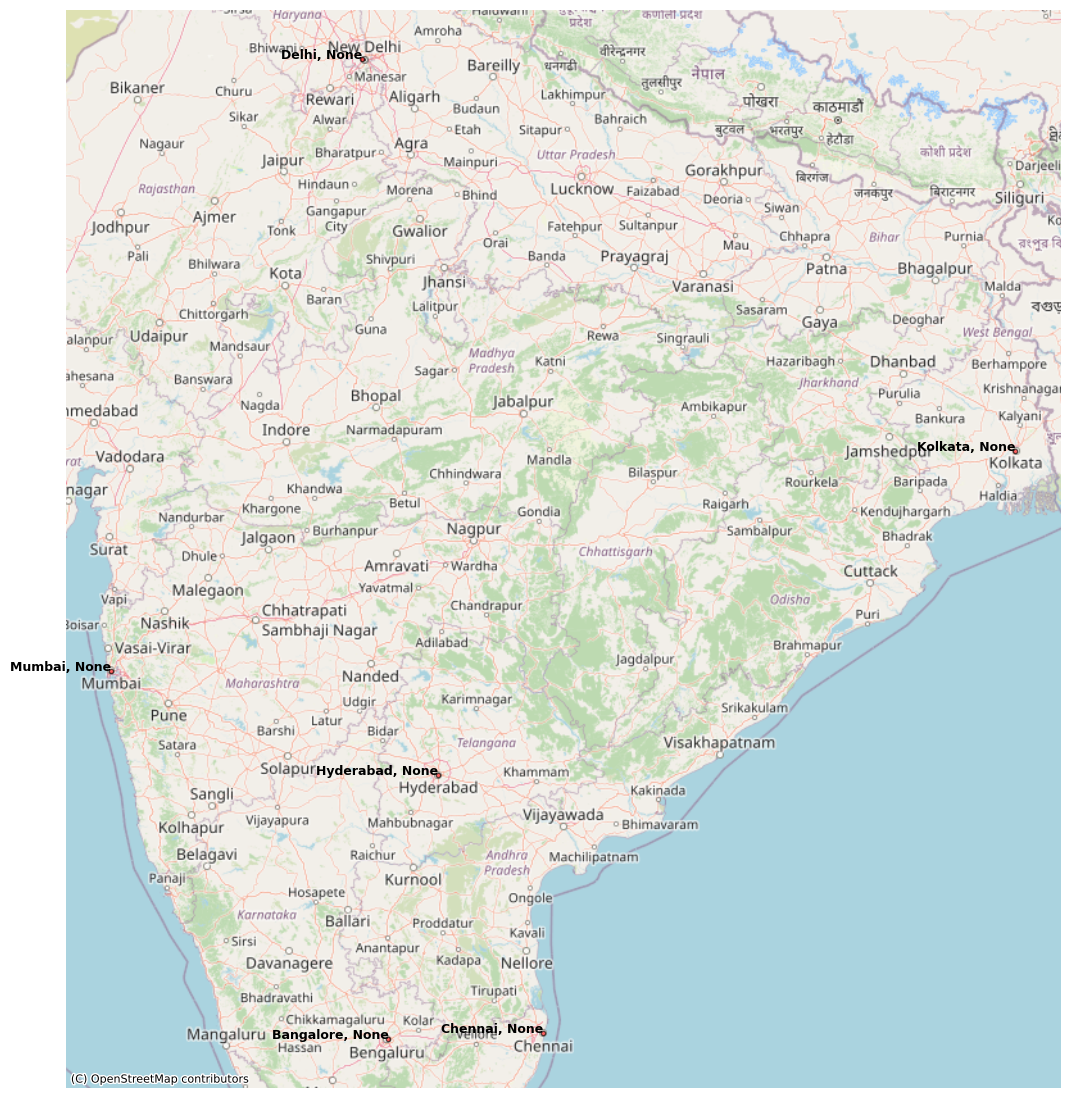

In [16]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time
from shapely.geometry import Point

df = pd.DataFrame({'destination_city': ['Mumbai', 'Delhi', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai']})

df = df.drop_duplicates(subset=['destination_city'])

geolocator = Nominatim(user_agent="geo_plotting", timeout=10)  # Increased timeout

def get_coordinates_and_state(city):
    retries = 5
    for i in range(retries):
        try:
            location = geolocator.geocode(city, timeout=10)  # Increase timeout
            if location:
                address = location.raw.get('address', {})
                state = address.get('state')  # Get the state name
                return location.latitude, location.longitude, state
        except (GeocoderTimedOut, GeocoderServiceError):
            print(f"Retry {i+1}/{retries} for {city}...")
            time.sleep(2)  # Wait before retrying
    return None, None, None  # Return None if all retries fail

# Apply geocoding to get coordinates and state
df['latitude'], df['longitude'], df['state'] = zip(*df['destination_city'].apply(get_coordinates_and_state))

# Drop rows where geocoding failed
df = df.dropna(subset=['latitude', 'longitude'])

# Convert to GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326").to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(14, 14))
gdf.plot(ax=ax, color='red', alpha=0.6, edgecolor='k', markersize=10)  # Fixed size for markers

# Add OpenStreetMap basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Annotate city names and states
for x, y, label, state in zip(gdf.geometry.x, gdf.geometry.y, gdf['destination_city'], gdf['state']):
    ax.text(x, y, f"{label}, {state}", fontsize=9, ha='right', color='black', weight='bold')

# Remove axis for better visualization
ax.set_axis_off()

plt.show()


In [17]:
pd.DataFrame(data['duration'].describe())

,duration
count,300153.000000
mean,12.221021
std,7.191997
min,0.830000
25%,6.830000
50%,11.250000
75%,16.170000
max,49.830000


In [18]:
pd.DataFrame(data['days_left'].describe())

,days_left
count,300153.000000
mean,26.004751
std,13.561004
min,1.000000
25%,15.000000
50%,26.000000
75%,38.000000
max,49.000000


In [19]:
pd.DataFrame(data['price'].describe())

,price
count,300153.000000
mean,20889.660523
std,22697.767366
min,1105.000000
25%,4783.000000
50%,7425.000000
75%,42521.000000
max,123071.000000


In [20]:
len(set(data['price'])), data.shape

(12157, (300153, 12))

In [21]:
pd.DataFrame(data['class'].value_counts())

,class
Economy,206666
Business,93487


# PreProcessing

In [22]:
data.columns 

Index(['Unnamed: 0', 'airline', 'flight', 'source_city', 'departure_time',
       'stops', 'arrival_time', 'destination_city', 'class', 'duration',
       'days_left', 'price'],
      dtype='object')

In [23]:
data=data.drop(columns=['Unnamed: 0', 'flight'])

In [24]:
data.isnull().sum()

airline             0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [25]:
data.sample()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
282719,Vistara,Hyderabad,Night,one,Evening,Bangalore,Business,21.67,45,38099


In [26]:
raw=data.copy()

In [27]:
set(raw['class'])

{'Business', 'Economy'}

In [28]:
raw['class']=raw['class'].replace({'Business':1,
                                   'Economy':0})

In [29]:
set(raw['class'])

{0, 1}

In [30]:
raw.stops=pd.factorize(raw.stops)[0]

In [31]:
set(raw.stops)

{0, 1, 2}

In [32]:
raw=raw.join(pd.get_dummies(raw.airline, prefix='airline')).drop(columns=['airline'])

raw=raw.join(pd.get_dummies(raw.source_city, prefix='source_city')).drop(columns=['source_city'])

raw=raw.join(pd.get_dummies(raw.destination_city, prefix='destination_city')).drop(columns=['destination_city'])

raw=raw.join(pd.get_dummies(raw.arrival_time, prefix='arrival_time')).drop(columns=['arrival_time'])

raw=raw.join(pd.get_dummies(raw.departure_time, prefix='departure_time')).drop(columns=['departure_time'])



In [33]:
raw.sample()

,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,...,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night
272960,1,1,19.92,10,55983,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


# Train regression model

**RandomForestRegressor is a supervised machine learning algorithm used for predicting continuous numerical values by averaging the outputs of multiple decision trees.**

**Each tree is trained on a random subset of the data and features—a process known as bagging—which introduces diversity and reduces overfitting. The final prediction is obtained by aggregating the individual predictions from all trees, typically through averaging, resulting in improved accuracy and robustness.**

**This ensemble approach allows RandomForestRegressor to capture complex, non-linear relationships in data without requiring extensive preprocessing or feature scaling. It is widely used in various applications, including stock price forecasting, real estate valuation, and time series prediction.**

https://www.youtube.com/watch?v=X1MRbEnEq2s&ab_channel=SuperDataScience  V 

https://www.youtube.com/watch?v=YUsx5ZNlYWc&ab_channel=Ryan%26MattDataScience  X


In [34]:
X = raw.drop(columns='price')

y= raw.price

In [35]:
X_train ,X_test , y_train , y_test = train_test_split(X, y, test_size=0.2)

In [36]:
reg= RandomForestRegressor(n_jobs=-1)


In [37]:
reg.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [38]:
reg

RandomForestRegressor(n_jobs=-1)

​The reg.score(X, y) method in RandomForestRegressor computes the R² score (coefficient of determination), indicating how well the model's predictions match the actual target values. An R² of 1.0 signifies perfect predictions, 0.0 means the model performs no better than predicting the mean of the target values, and negative values indicate worse performance than this baseline. This metric provides a quick assessment of model performance, but for a comprehensive evaluation, consider additional metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).

In [39]:
reg.score(X_test, y_test)

0.9853402447922518

An R² score of 0.98527 from reg.score(X_test, y_test) indicates that your RandomForestRegressor model explains approximately 98.5% of the variance in the test data. This suggests a strong fit between the model's predictions and the actual target values.​

In [40]:
from sklearn.metrics import *

The from sklearn.metrics import * statement imports all available functions and classes from the sklearn.metrics module, which provides a comprehensive suite of tools for evaluating machine learning models. These tools include:​

Classification Metrics: Functions like accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, and confusion_matrix are used to assess the performance of classification models.​

Regression Metrics: Functions such as mean_squared_error, mean_absolute_error, r2_score, and explained_variance_score help evaluate regression models.​

Clustering Metrics: Metrics like adjusted_rand_score, normalized_mutual_info_score, and silhouette_score are used to assess clustering algorithms.​

Pairwise Metrics: Functions like pairwise_distances and pairwise_kernels compute distances or similarities between pairs of samples.​

Utility Functions: Tools such as make_scorer and get_scorer assist in creating custom scoring functions and retrieving predefined scorers.​

In [41]:
import math

In [42]:
y_pred= reg.predict(X_test)

In [43]:
print(f"R2: {r2_score(y_test, y_pred):.3f}")

print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")

print(f"R-MSE: {math.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

R2: 0.985
MAE: 1070.775
MSE: 7538994.988
R-MSE: 2745.723


The model demonstrates high predictive accuracy, as evidenced by the R² value close to 1. 

The MAE and RMSE values suggest that, on average, predictions are within a reasonable range of the actual prices.

However, the relatively higher RMSE compared to MAE indicates the presence of some larger errors, which could be due to outliers or specific instances where the model's predictions deviate more significantly.

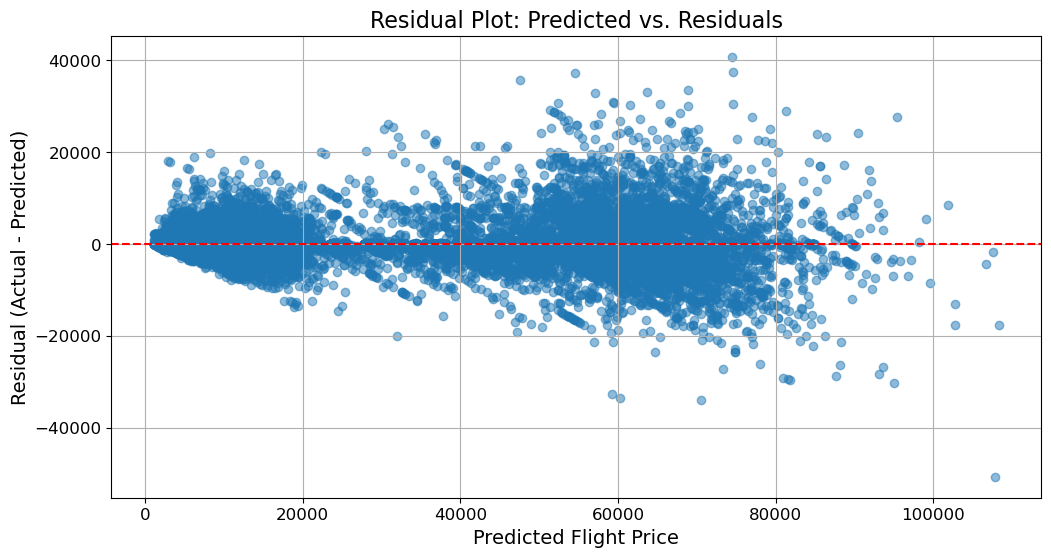

In [44]:

residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Flight Price", fontsize=14)
plt.ylabel("Residual (Actual - Predicted)", fontsize=14)
plt.title("Residual Plot: Predicted vs. Residuals", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()


Centered residuals: The residuals are generally centered around the 0 line, which is what we expect in a good model.

No clear linear pattern: That's a sign your model isn't systematically under- or over-predicting across all price ranges.

Densely packed residuals: Many points are close to the zero line, indicating overall strong performance.



In [45]:
from termcolor import colored

print(colored("Meta data regarding the predicted value:", color="cyan", attrs=["bold"]))

pd.DataFrame(raw.price.describe())

Meta data regarding the predicted value:


,price
count,300153.000000
mean,20889.660523
std,22697.767366
min,1105.000000
25%,4783.000000
50%,7425.000000
75%,42521.000000
max,123071.000000


In [46]:
len(y_pred),len(y_test)

(60031, 60031)

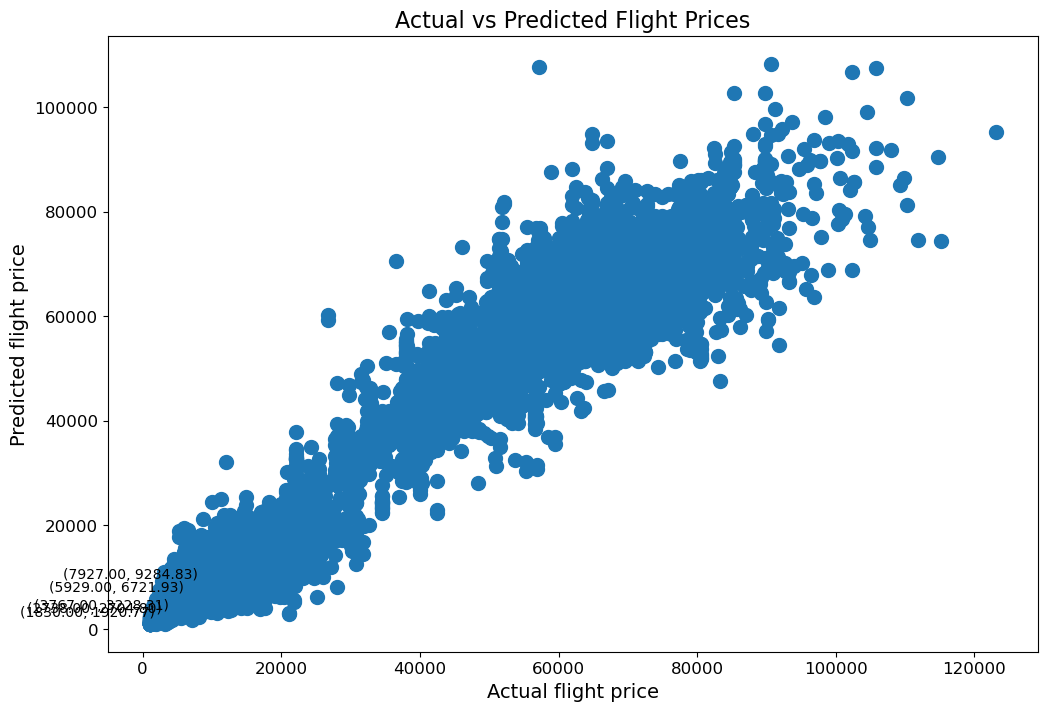

In [47]:


labels = [f"({np.array(y_test)[i]:.2f}, {np.array(y_pred)[i]:.2f})" for i in range(len(y_test))]

np.random.seed(42) 
indices_to_label = np.random.choice(len(y_test), size=5, replace=False)

plt.figure(figsize=(12, 8))
plt.scatter(np.array(y_test), y_pred, s=100)

plt.xlabel("Actual flight price", fontsize=14)
plt.ylabel("Predicted flight price", fontsize=14)
plt.title("Actual vs Predicted Flight Prices", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i in indices_to_label:
    plt.text(np.array(y_test)[i], np.array(y_pred)[i], labels[i],
             fontsize=10, ha='right', va='bottom')

plt.show()


In [48]:
importances = reg.feature_importances_
feature_names = X_train.columns

feat_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feat_imp_df.head(5)

,Feature,Importance
1,class,0.880393
2,duration,0.057206
3,days_left,0.018600
9,airline_Vistara,0.004921
5,airline_Air_India,0.004917


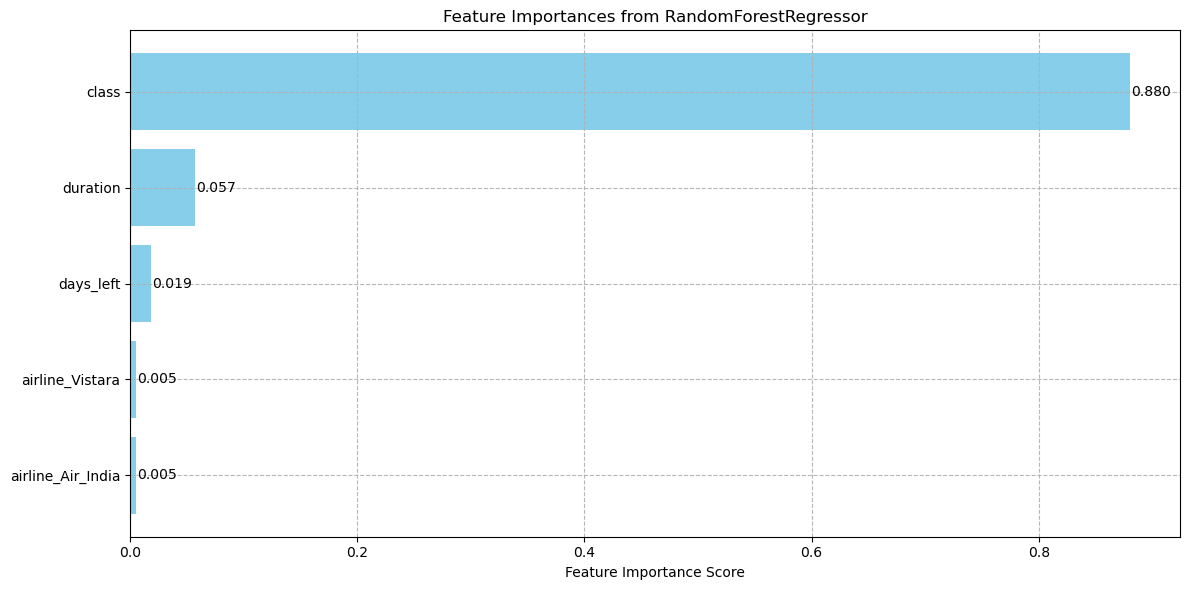

In [49]:
plt.figure(figsize=(12, 6))
bars = plt.barh(feat_imp_df["Feature"].head(5),
                feat_imp_df["Importance"].head(5),
                color='skyblue')

plt.xlabel("Feature Importance Score")
plt.title("Feature Importances from RandomForestRegressor")
plt.gca().invert_yaxis() 
plt.grid(True, linestyle="--", alpha=0.9)

# Add value labels next to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001,              
             bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}",         
             va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [50]:
top_features = feat_imp_df["Feature"].head(5)


print("\nTop 5 Feature Summary:\n")



pd.DataFrame({
    "Feature": top_features,
    "Min": X_train[top_features].min().values,
    "Max": X_train[top_features].max().values,
    "Unique Values": X_train[top_features].nunique().values
})


Top 5 Feature Summary:



,Feature,Min,Max,Unique Values
1,class,0.00,1.00,2
2,duration,0.83,49.83,473
3,days_left,1.00,49.00,49
9,airline_Vistara,0.00,1.00,2
5,airline_Air_India,0.00,1.00,2


In [51]:
sample_10_p=X_train.shape[0]*0.25

sample_10_p=round(sample_10_p, 0)

sample_10_p = int(sample_10_p)

In [52]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import *

from scipy.stats  import *

In [53]:


reg = RandomForestRegressor(n_jobs=-1, random_state=42)

param_grid = {
    'n_estimators': [50],         # Lower number of trees
    'max_depth': [10],            # Only one depth
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(
    reg,
    param_grid,
    cv=2,            # Only 2-fold CV
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train[top_features][:sample_10_p], y_train[:sample_10_p])

print("Best Params:", grid_search.best_params_)

best_regressor= grid_search.best_estimator_



Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


Sure! Here's a clear explanation of what the code does, in words only:

This script performs a quick hyperparameter tuning of a `RandomForestRegressor` model using only the top 5 most important features. 

It sets up a simple grid of parameters with minimal options to reduce computation time. The tuning is done using `GridSearchCV` with 2-fold cross-validation and only 10% of the training data. After fitting the model on the selected features and data subset, 

it retrieves the best-performing estimator from the grid search. This process helps in efficiently finding a decent model without consuming too many resources.

In [54]:
param_grid

{'n_estimators': [50],
 'max_depth': [10],
 'min_samples_split': [2],
 'min_samples_leaf': [1],
 'max_features': ['sqrt']}

In [55]:
grid_search

GridSearchCV(cv=2, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [50]},
             verbose=2)

In [56]:
best_regressor

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=50,
                      n_jobs=-1, random_state=42)

In [57]:
best_regressor.score(X_test[top_features][:sample_10_p], y_test[:sample_10_p])



0.944466998858429

In [58]:
y_pred= best_regressor.predict(X_test[top_features])

In [59]:
print(f"R2: {r2_score(y_test, y_pred):.3f}")

print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")

print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")

print(f"R-MSE: {math.sqrt(mean_squared_error(y_test, y_pred)):.3f}") 



R2: 0.944
MAE: 3140.019
MSE: 28558378.379
R-MSE: 5344.004


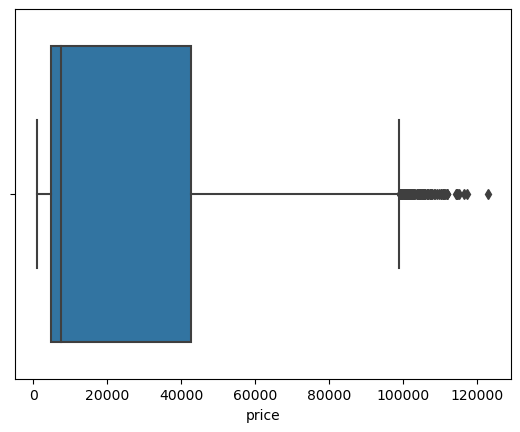

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=raw.price)
plt.show()


In [61]:
from scipy.stats import zscore

z_scores = zscore(raw.price)
outliers = raw[abs(z_scores) > 3]


In [62]:
outliers

,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,...,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night
206787,1,1,26.83,2,95657,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
206878,1,1,7.58,3,91575,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
210742,1,1,6.50,38,90281,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
210743,1,1,13.83,38,90281,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
215854,1,1,13.83,1,90057,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299018,1,1,10.17,25,89537,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
299407,1,1,10.00,33,89537,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
299458,1,1,10.17,34,89537,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
299700,1,1,10.00,39,89537,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


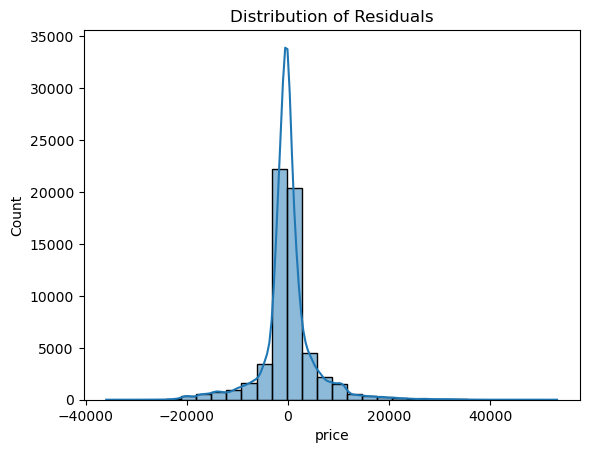

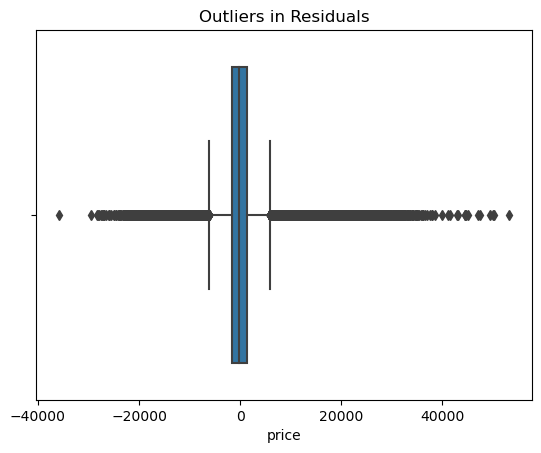

In [63]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.show()

sns.boxplot(x=residuals)
plt.title("Outliers in Residuals")
plt.show()


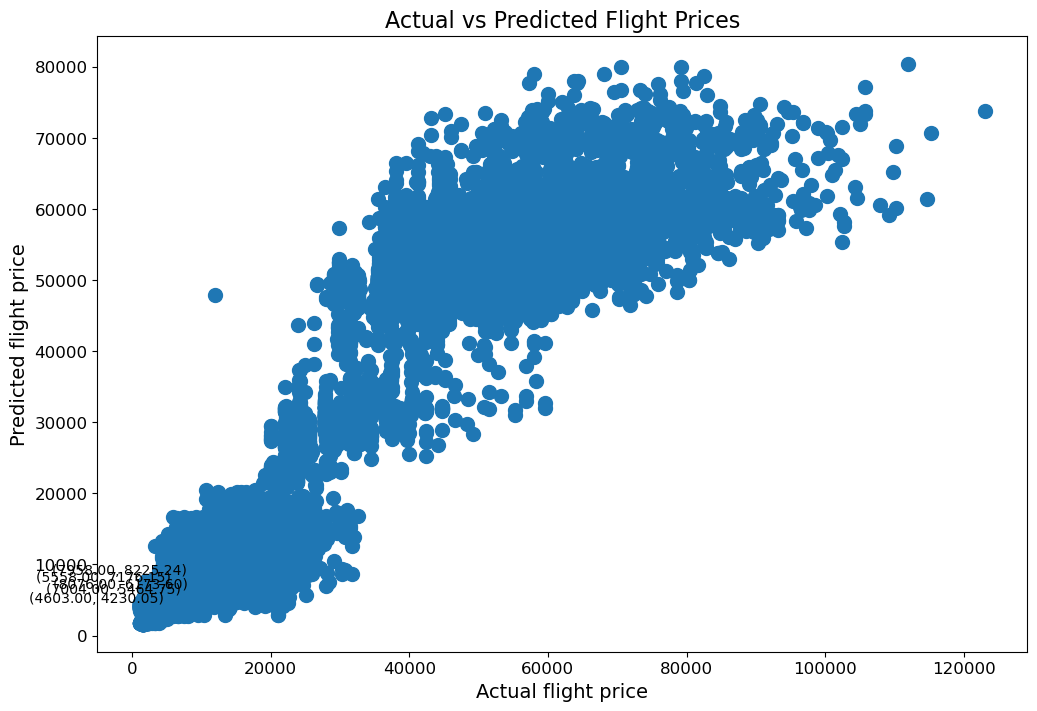

In [64]:
sample_y_test = np.array(y_test[:sample_10_p])
sample_y_pred = np.array(y_pred[:sample_10_p])

labels = [f"({sample_y_test[i]:.2f}, {sample_y_pred[i]:.2f})" for i in range(sample_10_p)]
    
np.random.seed(42)
indices_to_label = np.random.choice(sample_10_p, size=5, replace=False)

plt.figure(figsize=(12, 8))
plt.scatter(sample_y_test, sample_y_pred, s=100)

plt.xlabel("Actual flight price", fontsize=14)
plt.ylabel("Predicted flight price", fontsize=14)
plt.title("Actual vs Predicted Flight Prices", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i in indices_to_label:
    plt.text(sample_y_test[i], sample_y_pred[i], labels[i], fontsize=10, ha='right', va='bottom')

plt.show()


In [65]:

# Assume y_train is a Pandas Series
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter indices where target is within bounds
mask = (y_train >= lower_bound) & (y_train <= upper_bound)

# Apply mask to X_train and y_train
X_train_clean = X_train[top_features].iloc[:sample_10_p][mask]
y_train_clean = y_train.iloc[:sample_10_p][mask]


C:\Users\segev\AppData\Local\Temp\ipykernel_20116\2785341803.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_clean = X_train[top_features].iloc[:sample_10_p][mask]


In [66]:
reg = RandomForestRegressor(n_jobs=-1, random_state=42)

param_grid = {
    'n_estimators': [50],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(
    reg,
    param_grid,
    cv=2,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_clean, y_train_clean)

print("Best Params:", grid_search.best_params_)
best_regressor = grid_search.best_estimator_


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [67]:

y_pred = best_regressor.predict(X_test[top_features])

# Evaluate
print(f"R2: {r2_score(y_test, y_pred):.3f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.3f}")
print(f"R-MSE: {math.sqrt(mean_squared_error(y_test, y_pred)):.3f}")


R2: 0.944
MAE: 3137.739
MSE: 28630586.540
R-MSE: 5350.756


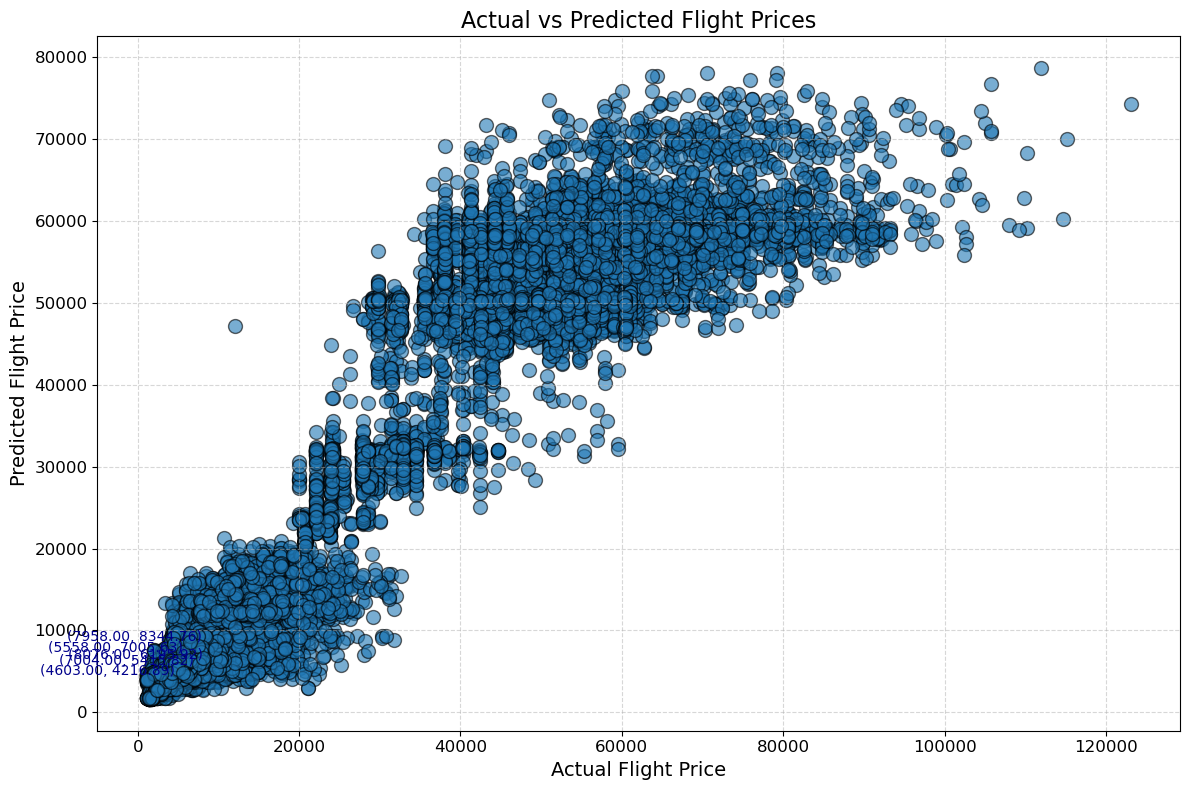

In [68]:

sample_y_test = np.array(y_test[:sample_10_p])
sample_y_pred = np.array(y_pred[:sample_10_p])

labels = [f"({sample_y_test[i]:.2f}, {sample_y_pred[i]:.2f})" for i in range(sample_10_p)]

np.random.seed(42)
indices_to_label = np.random.choice(sample_10_p, size=5, replace=False)

plt.figure(figsize=(12, 8))
plt.scatter(sample_y_test, sample_y_pred, s=100, alpha=0.6, edgecolor='k')

plt.xlabel("Actual Flight Price", fontsize=14)
plt.ylabel("Predicted Flight Price", fontsize=14)
plt.title("Actual vs Predicted Flight Prices", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

for i in indices_to_label:
    plt.text(sample_y_test[i], sample_y_pred[i], labels[i],
             fontsize=10, ha='right', va='bottom', color='darkblue')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
